In [1]:
import os, re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, f1_score
from sklearn.neighbors import KNeighborsClassifier
from tabulate import tabulate

data_directory = "./train-mails"
test_directory = "./test-mails"

In [2]:
'''Remove the word “Subject:” from the subject line, remove all non-alphabetic characters, and remove all single-character words.'''
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\bSubject:|[^\w\s]|\b\w\b', "", text)
    words = word_tokenize(text)
    words = [word for word in words if len(word) > 1]
    return ' '.join(words)

In [3]:
'''Load the data from the directory and preprocess it.'''
def load_spam_data(data_dir):
    data = []
    labels = []
    for filename in os.listdir(data_dir):
        if filename.startswith("spm"):
            labels.append(1)
        else:
            labels.append(0)
        with open(os.path.join(data_dir, filename), 'r', encoding='utf-8') as file:
            email_text = file.read()
            preprocessed_text = preprocess_text(email_text)
            data.append(preprocessed_text)
    return data, labels

In [4]:
def run_classifier(classifier_type, dict_size, k_param, c_param):
    train_data, train_labels = load_spam_data(data_directory)
    test_data, test_labels = load_spam_data(test_directory)
    vectorizer = CountVectorizer(max_features=dict_size)
    X_train = vectorizer.fit_transform(train_data)
    X_test = vectorizer.transform(test_data)
    classifier = None
    label_type = None
    label_value = None
    if classifier_type == 'nb':
        classifier = MultinomialNB()
        label_type = 'Dict size'
        label_value = dict_size
    elif classifier_type == 'knn':
        classifier = KNeighborsClassifier(n_neighbors=k_param)
        label_type = 'K-value'
        label_value = k_param
    elif classifier_type == 'lr' or classifier_type == 'lr-compared':
        classifier = LogisticRegression(C=c_param)
        label_type = 'C-value'
        label_value = c_param
    classifier.fit(X_train, train_labels)
    fpr, tpr, thresholds = roc_curve(test_labels, classifier.predict_proba(X_test)[:, 1])
    roc_auc = round(auc(fpr, tpr), 5)
    test_predictions = classifier.predict(X_test)
    train_predictions = None
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - '+str.upper(classifier_type)+' Classifier')
    plt.plot(fpr,tpr,label='Classifier: '+str.upper(classifier_type)+', '+str(label_type)+': '+str(label_value)+', AUC: '+str(roc_auc), lw=2)
    plt.legend(loc="lower right")
    if classifier_type == 'lr-compared':
        train_predictions = classifier.predict(X_train)
    test_table_data = [
        ["Metric", "Value"],
        ["Accuracy", accuracy_score(test_labels, test_predictions)],
        ["Precision", precision_score(test_labels, test_predictions)],
        ["Recall", recall_score(test_labels, test_predictions)],
        ["F1-score", f1_score(test_labels, test_predictions)],
        ["AUC", roc_auc],
    ]
    metric_table = tabulate(test_table_data, headers="firstrow", tablefmt="grid")
    with open('./'+classifier_type+'_results/'+classifier_type+'_results.txt', 'a') as f:
        f.write('\n'+str.upper(classifier_type)+' CLASSIFIER - '+str(label_type)+': '+str(label_value)+', Test metrics'+'\n')
        f.write(metric_table+'\n')
        if classifier_type == 'lr-compared':
            f.write('\n'+'Train metrics'+'\n')
            table_data = [
                ["Recall", recall_score(train_labels, train_predictions)],
                ["Precision", precision_score(train_labels, train_predictions)],
            ]
            train_metric_table = tabulate(table_data, headers="firstrow", tablefmt="grid")
            f.write(train_metric_table+'\n')

In [5]:
'''Compare performances between NB Classifier, KNN Classifier and LR Classifier.'''
def compare_all_approaches():
    run_classifier('nb', 3000, _, _)
    run_classifier('knn', 3000, 20, _)
    run_classifier('lr', 3000, _, 100)
    plt.title('Receiver Operating Characteristic - All Classifiers')

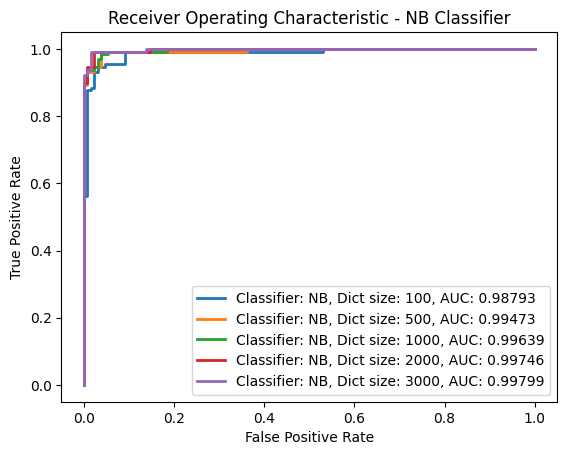

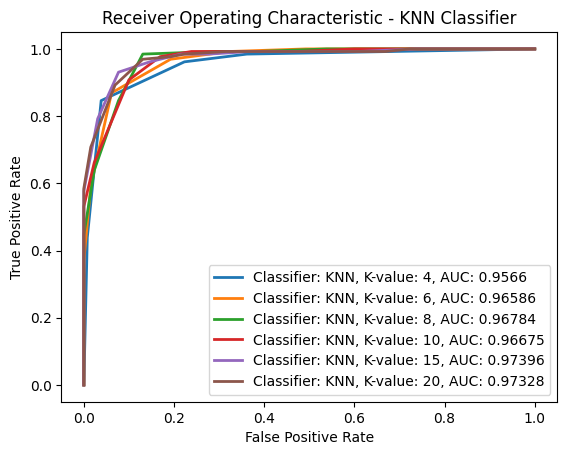

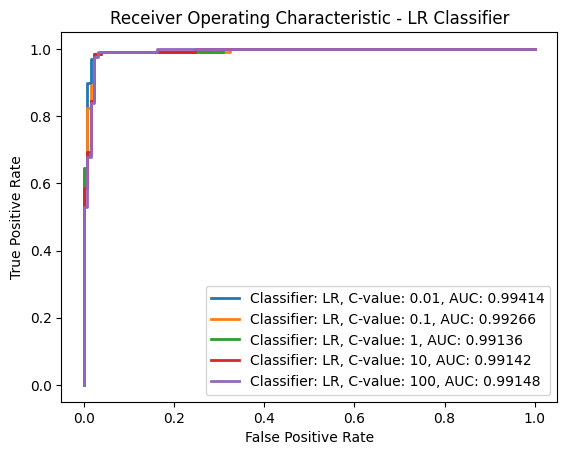

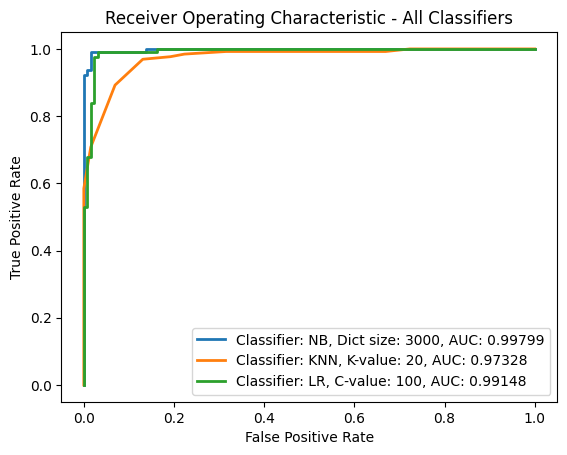

In [6]:
for classifier_to_run in ['nb', 'knn', 'lr', 'lr-compared']:    
    if not os.path.exists('./'+classifier_to_run+'_results'):
        os.mkdir('./'+classifier_to_run+'_results')
    elif os.path.exists('./'+classifier_to_run+'_results/'+classifier_to_run+'_results.txt'):
        os.remove('./'+classifier_to_run+'_results/'+classifier_to_run+'_results.txt')

run_classifier('nb', 100, _, _)
run_classifier('nb', 500, _, _)
run_classifier('nb', 1000, _, _)
run_classifier('nb', 2000, _, _)
run_classifier('nb', 3000, _, _) #best
plt.show()
plt.clf()
run_classifier('knn', 3000, 4, _)
run_classifier('knn', 3000, 6, _)
run_classifier('knn', 3000, 8, _)
run_classifier('knn', 3000, 10, _)
run_classifier('knn', 3000, 15, _)
run_classifier('knn', 3000, 20, _) #best
plt.show()
plt.clf()
run_classifier('lr', 3000, _, 0.01)
run_classifier('lr', 3000, _, 0.1)
run_classifier('lr', 3000, _, 1)
run_classifier('lr', 3000, _, 10)
run_classifier('lr', 3000, _, 100) #best
plt.show()
plt.clf()
run_classifier('lr-compared', 3000, _, 0.01)
run_classifier('lr-compared', 3000, _, 0.1)
run_classifier('lr-compared', 3000, _, 1)
run_classifier('lr-compared', 3000, _, 10)
run_classifier('lr-compared', 3000, _, 100) #best
plt.clf()
compare_all_approaches()
plt.show()